<font color='blue'> **27. Delay Interbed Drainage** </font> 

In [136]:
import os ; import pathlib as pl ; from pathlib import Path ; import flopy ; import matplotlib as mpl ; import os; import sys; 
import matplotlib.pyplot as plt ; import numpy as np ; from flopy.plot.styles import styles ; from modflow_devtools.misc import get_env, timed
sim_name = "ex-gwf-csub-p02" ; workspace = Path("./27") ; exe_name = 'E:\\15_REPOS\\00_BETAMI\\bin\\mf6.exe' 
write = get_env("WRITE", True) ; run = get_env("RUN", True)  ;  import pandas as pd 

(np.float64(-0.5), np.float64(944.5), np.float64(386.5), np.float64(-0.5))

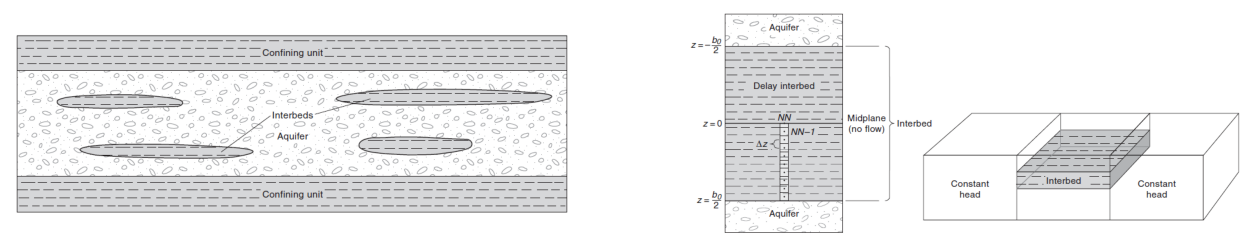

In [137]:
fig = plt.figure(figsize=(16, 12))                                                    
ax = fig.add_subplot(121,aspect="equal" ) ;image=plt.imread('E:/15_REPOS/00_BETAMI/bin/Flopy_3099/Fig/PDF_fig_27_SUB_2.PNG') ;ax.imshow(image) ;ax.axis('off')  
ax = fig.add_subplot(122,aspect="equal" ) ;image=plt.imread('E:/15_REPOS/00_BETAMI/bin/Flopy_3099/Fig/PDF_fig_27_SUB_1.PNG') ;ax.imshow(image) ;ax.axis('off')  

In [138]:
parameters = {"ex-gwf-csub-p02a": {"head_based": True ,"bed_thickness": (1.0,),"kv": (2.5e-06,),"ndelaycells": 19,},
              "ex-gwf-csub-p02b": {"head_based": False,"bed_thickness": (1.0,),"kv": (2.5e-06,),"ndelaycells": 19,},
              "ex-gwf-csub-p02c": {"head_based": True ,"bed_thickness": (1.0, 2.0, 5.0, 10.0, 20.0, 50.0, 100.0),
                                   "kv": (2.5e-06, 1e-05, 6.25e-05, 0.00025, 0.001, 0.00625, 0.025),"ndelaycells": 1001,},}
length_units = "meters" ; time_units = "days" ; nlay = 1 ;ncol = 3 ;nrow = 1 ;delr = 1 ;delc = 1 ;top = 0 ;botm = -1000 ; strt = 0 ;icelltype = 0  
nper           = 1 ; tdis_ds = ((1000.0, 100, 1.05),)  
nouter = 1000 ; ninner = 300 ; hclose = 0.000000001 ; rclose = 0.000001 ; linaccel = "bicgstab" ; relax = 0.97  ; k11 = 1000000 # = 1x10^6 (m/d) ???
sgm = 1.7  ;sgs = 2.0  ;tau0 = 1000.0  ;cg_theta = 0.2  ;ske = 1.0e-5  ;skv = 1.0e-2  ;theta= 0.45  ;h0= 1.0  ;head_offset = 1.0     ;c6 = []
for j in range(0, ncol, 2):     c6.append([0, 0, j, strt])

In [139]:
def build_models(name ,subdir_name =".", head_based=True ,bed_thickness=1.0 ,kv=2e-6 ,ndelaycells=19,):
    if head_based:    hb_bool = True ; pc0 = head_offset  ; tsgm = None ; tsgs = None
    else:             hb_bool = None ; pc0 = -head_offset ; tsgm = sgm  ; tsgs = sgs
    sub6 = [[0 ,0 ,0 ,1 ,"delay" ,pc0 ,bed_thickness ,1.0 ,skv ,ske ,theta ,kv ,h0 ,"ib1"]]

    opth = f"{name}.csub.obs" ; csub_csv=opth+".csv"
    obs =  [("tcomp" ,"interbed-compaction" ,(0 ,)) ,("sk" ,"sk" ,(0 ,)) ,("qtop" ,"delay-flowtop" ,(0 ,)) ,("qbot" ,"delay-flowbot" ,(0 ,)) ,]
    for k in range(ndelaycells): tag = f"H{k + 1:04d}" ; obs.append((tag, "delay-head", (0,), (k,)))
    if not head_based:
        iposm = int(ndelaycells / 2) + 1 ; iposb = ndelaycells - 1
        obs += [("est", "delay-estress", (0,), (0,))     ,("esm", "delay-estress", (0,)     , (iposm,)),
                ("esb", "delay-estress", (0,), (iposb,)) ,("gs", "gstress-cell", (0, 0, 1)) ,("es", "estress-cell", (0, 0, 1)),        ]
    orecarray = {csub_csv: obs}   ; head_filerecord=f"{sim_name}.hds" ; budget_filerecord=f"{sim_name}.cbc"
    
    sim_ws = os.path.join(workspace, name)
    if subdir_name is not None: sim_ws = os.path.join(sim_ws, subdir_name)
    sim = flopy.mf6.MFSimulation(sim_name=name, sim_ws=sim_ws, exe_name="mf6")
    flopy.mf6.ModflowTdis   (sim, nper=nper, perioddata=tdis_ds, time_units=time_units)
    flopy.mf6.ModflowIms    (sim,outer_maximum=nouter,outer_dvclose=hclose,linear_acceleration=linaccel,inner_maximum=ninner,inner_dvclose=hclose,
                             relaxation_factor=relax,rcloserecord=f"{rclose} strict") 
    gwf = flopy.mf6.ModflowGwf  (sim, modelname=name, save_flows=True, newtonoptions="newton")
    flopy.mf6.ModflowGwfdis (gwf ,length_units=length_units ,nlay=nlay ,nrow=nrow ,ncol=ncol ,delr=delr ,delc=delc ,top=top ,botm=botm)
    flopy.mf6.ModflowUtlobs (gwf ,digits=10 ,print_input=True ,continuous={"gwf_obs.csv":[("h1_1_2" ,"HEAD" ,(0 ,0 ,1))]})
    flopy.mf6.ModflowGwfic  (gwf ,strt=strt)
    flopy.mf6.ModflowGwfnpf (gwf ,icelltype=icelltype ,k=k11 ,save_specific_discharge=True ,)
    flopy.mf6.ModflowGwfsto (gwf ,iconvert=icelltype ,ss=0.0 ,sy=0 ,transient={0:True})
    csub = flopy.mf6.ModflowGwfcsub (gwf ,print_input=True ,save_flows=True ,head_based=hb_bool ,ndelaycells=ndelaycells ,boundnames=True ,ninterbeds=1, 
                                     sgm=tsgm ,sgs=tsgs ,cg_theta=cg_theta ,cg_ske_cr=0.0 ,beta=0.0 ,packagedata=sub6)  
    csub.obs.initialize(filename=opth, digits=10, print_input=True, continuous=orecarray)
    flopy.mf6.ModflowGwfchd (gwf, stress_period_data={0: c6})
    flopy.mf6.ModflowGwfoc   (gwf,head_filerecord=head_filerecord,budget_filerecord=budget_filerecord,saverecord=[("HEAD","ALL"),("BUDGET","ALL")])


    return sim
def write_models(sim, silent=True): sim.write_simulation(silent=silent)
def run_models  (sim, silent=True): 
    success, buff = sim.run_simulation(silent=silent)  ;     assert success, buff
def scenarios(idx, silent=True):
    key = list(parameters.keys())[idx]   ; interbed_thickness = parameters[key]["bed_thickness"] 
    interbed_kv = parameters[key]["kv"]  ; params = parameters[key].copy()
    if len(interbed_thickness) == 1:
        params["bed_thickness"] = interbed_thickness[0]  ; params["kv"] = interbed_kv[0]
        sim = build_models(key, **params)
        if write: write_models(sim, silent=silent)
        if run:   run_models(sim, silent=silent)
    else:
        for b, kv in zip(interbed_thickness, interbed_kv):
            for head_based in (True, False):
                if head_based:     subdir_name = "hb-"
                else:              subdir_name = "es-"
                subdir_name += f"{int(b):03d}"  ; params["head_based"] = head_based ; params["bed_thickness"] = b ; params["kv"] = kv
                sim = build_models(key, subdir_name=subdir_name, **params)
                if write: write_models(sim, silent=silent)
                if run:   run_models(sim, silent=silent)
scenarios(0) ; scenarios(1); scenarios(2)

In [140]:
sim_ws = Path(workspace, list(parameters.keys())[0])                                       ; arrow_props = dict(facecolor="black", arrowstyle="-", lw=0.5)
sim = flopy.mf6.MFSimulation.load(sim_ws = sim_ws ,exe_name=exe_name, verbosity_level=0)   ; gwf = sim.get_model(list(parameters.keys())[0])
hobj = gwf.output.head()  ;  head = hobj.get_data() 

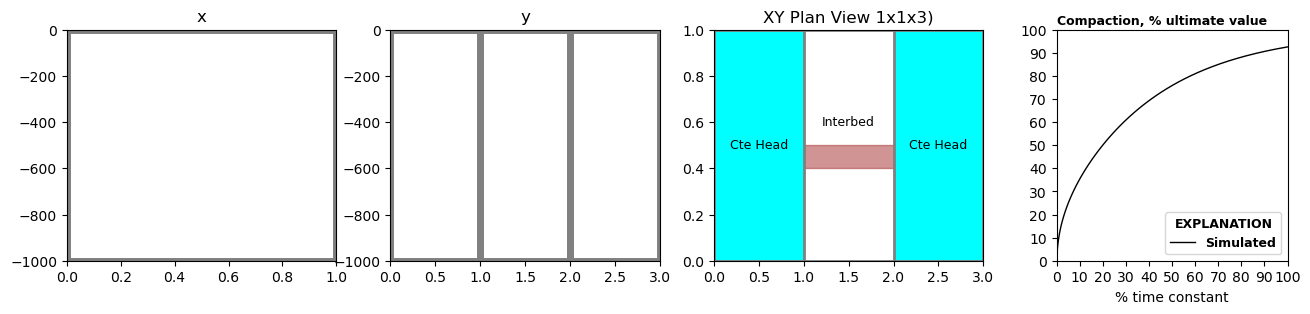

In [158]:
fig = plt.figure(figsize=(16, 3))        
ax = fig.add_subplot(141) ; pxs = flopy.plot.PlotCrossSection(model=gwf, ax=ax, line={"column": 0}) ; pxs.plot_grid(linewidth=5) ; ax.set_title("x") 
ax = fig.add_subplot(142) ; pxs = flopy.plot.PlotCrossSection(model=gwf, ax=ax, line={"row": 0})    ; pxs.plot_grid(linewidth=5) ; ax.set_title("y") 

ax = fig.add_subplot(143)  ; head = gwf.output.head().get_data()   ; h_L0 = pd.DataFrame(head[0,:,:]) ; 
pmv = flopy.plot.PlotMapView(model=gwf, ax=ax, layer=0) ; pmv.plot_bc("CHD", plotAll=True,color="cyan") ; ax.set_title("XY Plan View 1x1x3)") 
pmv.plot_grid(linewidth=2) ;   
styles.add_text(ax=ax ,text="Cte Head" ,x=0.5 ,y=0.5 ,bold=False ,italic=False ,transform=False ,va="center" ,ha="center" ,fontsize=9)
styles.add_text(ax=ax ,text="Cte Head" ,x=2.5 ,y=0.5 ,bold=False ,italic=False ,transform=False ,va="center" ,ha="center" ,fontsize=9)
styles.add_text(ax=ax ,text="Interbed" ,x=1.5 ,y=0.6 ,bold=False ,italic=False ,transform=False ,va="center" ,ha="center" ,fontsize=9)
ax.fill_between([1 ,2] ,y1=0.4 ,y2=0.5 ,color="brown" ,alpha=0.5)                 ; #cb = pmv.plot_array(head, cmap="jet", alpha=0.05)

ax = fig.add_subplot(144, aspect="equal")   ; ax.plot(tpct,100 * cobs["TCOMP"] / skv,label="Simulated",color="black",lw=1,zorder=100,)
leg = styles.graph_legend(ax, loc="lower right")  ; ax.set_xticks(np.arange(0, 110, 10)) ; ax.set_yticks(np.arange(0, 110, 10))
ax.set_xlabel("% time constant") ; ax.set_xlim(0, 100) ; ax.set_ylim(0, 100) ; styles.heading(ax, letter="Compaction, % ultimate value") ; plt.show() 